In [5]:
test_file = "/home/maelic/Documents/SGDiff/datasets/vg/test_no_rels.h5"

import h5py
import numpy as np

test_data = h5py.File(test_file, 'r+')
print(test_data.keys()) 
# remove all relations

for i in range(len(test_data['relationship_ids'])):
    relationship_ids = list(np.full((30,), -1, dtype=int)) # (62565, 30) int32
    relationship_objects = list(np.full((30,), -1, dtype=int)) #(62565, 30) int32
    relationship_predicates = list(np.full((30,), -1, dtype=int)) #(62565, 30) int32
    relationship_subjects = list(np.full((30,), -1, dtype=int)) # (62565, 30) int32
    relationships_per_image = 0

    test_data['relationship_ids'][i] = relationship_ids
    test_data['relationship_objects'][i] = relationship_objects
    test_data['relationship_predicates'][i] = relationship_predicates
    test_data['relationship_subjects'][i] = relationship_subjects
    test_data['relationships_per_image'][i] = relationships_per_image

test_data.close()

img_ids = [41, 97, 127, 155, 200, 207, 259, 305, 308, 313, 346, 349, 497, 557, 562, 615, 644, 683, 698, 813, 847, 895, 943, 1014, 1123, 1222, 1289, 1304, 1325, 1343, 1549, 1621, 1627, 1697, 1709, 1712, 1751, 1824, 2109, 2141, 2171, 2185, 2304, 2310, 2321, 2405, 2407, 2470, 2483, 2493, 2728, 2748, 2781, 2783, 2811, 2845, 2879, 2889, 2906, 2929, 2938, 2965, 2993, 3043, 3102, 3212, 3247, 3354, 3396, 3449, 3524, 3576, 3595, 3600, 3622, 3626, 3727, 3756, 3787, 3809, 3954, 4008, 4078, 4091, 4153, 4217, 4244, 4251, 4324, 4372, 4514, 4531, 4658, 4740, 4778, 4871, 4956, 4966, 4974, 4975, 4982, 5050, 5061]


<KeysViewHDF5 ['attributes_per_object', 'image_ids', 'image_paths', 'object_attributes', 'object_boxes', 'object_ids', 'object_names', 'objects_per_image', 'relationship_ids', 'relationship_objects', 'relationship_predicates', 'relationship_subjects', 'relationships_per_image']>


In [3]:
res_path = "/home/maelic/Documents/Scene-Graph-Benchmark-Cuda11.7/checkpoints/motifs2/inference/VG178_test/test_set_transformer"

import os
import json
import numpy as np
from tqdm import tqdm

def get_all_files(path):
    files = []
    for r, d, f in os.walk(path):
        for file in f:
            if '.json' in file:
                files.append(os.path.join(r, file))
    return files

# merge all files

files = get_all_files(res_path)

all_data = {}

for file in tqdm(files):
    with open(file, 'r') as f:
        data = json.load(f)
        img_id = file.split('/')[-1].split('.')[0]
        all_data[img_id] = data["0"]

  0%|          | 0/4993 [00:00<?, ?it/s]

100%|██████████| 4993/4993 [05:08<00:00, 16.17it/s]


In [ ]:
import h5py
import numpy as np
import os

image_ids = list(all_data.keys())
image_paths = [i+'.jpg' for i in image_ids]
all_attributes_per_object = [] # (606319, 30) int32
all_object_attributes = [] # (62565, 30) int32
all_object_boxes = [] # (62565, 30, 4) int32
all_object_ids = [] #(62565, 30) int32
all_object_names = [] #(62565, 30) int32
all_objects_per_image = [] #(62565,) int32
all_relationship_ids = [] # (62565, 30) int32
all_relationship_objects = [] #(62565, 30) int32
all_relationship_predicates = [] #(62565, 30) int32
all_relationship_subjects = [] # (62565, 30) int32
all_relationships_per_image = [] # (62565,) int32

rel_ids = 0
obj_ids = 0

for k, v in all_data.items():
    object_boxes = list(np.full((30,4), -1, dtype=int)) # (62565, 30, 4) int32
    object_ids = list(np.full((30,), -1, dtype=int)) #(62565, 30) int32
    object_names = list(np.full((30,), -1, dtype=int)) #(62565, 30) int32
    objects_per_image = 0
    relationship_ids = list(np.full((30,), -1, dtype=int)) # (62565, 30) int32
    relationship_objects = list(np.full((30,), -1, dtype=int)) #(62565, 30) int32
    relationship_predicates = list(np.full((30,), -1, dtype=int)) #(62565, 30) int32
    relationship_subjects = list(np.full((30,), -1, dtype=int)) # (62565, 30) int32
    relationships_per_image = 0 # (62565,) int32

    # get top 10 rel
    top_10_pairs = v['rel_pairs'][:5]

    # get corresponding objects
    objects_old_id_to_new = {}
    num_obj = 0
    rel_per_image = 0
    for i, pair in enumerate(top_10_pairs):

        if pair[1] not in objects_old_id_to_new.keys():
            obj_ids += 1
            object_ids[np.argmin(object_ids)] = obj_ids
            objects_old_id_to_new[pair[1]] = num_obj
            # get all values of first dim of object boxes
            object_boxes[np.where(object_boxes == np.array([-1,-1,-1,-1]))[0][0]] = np.array(v['bbox'][pair[1]], dtype=int)
            object_names[np.argmin(object_names)] = v['bbox_labels'][pair[1]]
            relationship_objects[np.argmin(relationship_objects)] = num_obj
            all_object_attributes.append(list(np.full((30,), -1, dtype=int)))
            num_obj += 1
        else:
            relationship_objects[np.argmin(relationship_objects)] = objects_old_id_to_new[pair[1]]
        
        if pair[0] not in objects_old_id_to_new.keys():
            obj_ids += 1
            object_ids[np.argmin(object_ids)] = obj_ids
            objects_old_id_to_new[pair[0]] = num_obj
            object_boxes[np.where(object_boxes == np.array([-1,-1,-1,-1]))[0][0]] = np.array(v['bbox'][pair[0]], dtype=int)
            object_names[np.argmin(object_names)] = v['bbox_labels'][pair[0]]
            relationship_subjects[np.argmin(relationship_subjects)] = num_obj
            all_object_attributes.append(list(np.full((30,), -1, dtype=int)))
            num_obj += 1
        else:
            relationship_subjects[np.argmin(relationship_subjects)] = objects_old_id_to_new[pair[0]]

        relationship_predicates[np.argmin(relationship_predicates)] = v['rel_labels'][i]
        relationship_ids[np.argmin(relationship_ids)] = rel_ids
        rel_ids += 1
        rel_per_image += 1
    
    assert(rel_per_image == 5)
    all_objects_per_image.append(num_obj)
    all_relationships_per_image.append(rel_per_image)

    all_object_boxes.append(object_boxes)
    all_object_ids.append(object_ids)
    all_object_names.append(object_names)
    all_attributes_per_object.append(list(np.full((30,), -1, dtype=int)))
    all_relationship_ids.append(relationship_ids)
    all_relationship_objects.append(relationship_objects)
    all_relationship_predicates.append(relationship_predicates)
    all_relationship_subjects.append(relationship_subjects)

dest_path = "pred_transformer.h5"

with h5py.File(dest_path, 'w') as f:
    f.create_dataset('image_ids', data=image_ids, dtype=np.int32)
    f.create_dataset('image_paths', data=image_paths)
    f.create_dataset('attributes_per_object', data=all_attributes_per_object, dtype=np.int32)
    f.create_dataset('object_attributes', data=all_object_attributes, dtype=np.int32)
    f.create_dataset('object_boxes', data=all_object_boxes)
    f.create_dataset('object_ids', data=all_object_ids, dtype=np.int32)
    f.create_dataset('object_names', data=all_object_names, dtype=np.int32)
    f.create_dataset('objects_per_image', data=all_objects_per_image, dtype=np.int32)
    f.create_dataset('relationship_ids', data=all_relationship_ids, dtype=np.int32)
    f.create_dataset('relationship_objects', data=all_relationship_objects, dtype=np.int32)
    f.create_dataset('relationship_predicates', data=all_relationship_predicates, dtype=np.int32)
    f.create_dataset('relationship_subjects', data=all_relationship_subjects, dtype=np.int32)
    f.create_dataset('relationships_per_image', data=all_relationships_per_image, dtype=np.int32)

In [6]:
import h5py
import numpy as np
import os

# remove all relations that are not topological
class_dict = json.load(open('/home/maelic/Documents/Scene-Graph-Benchmark-Cuda11.7/datasets/VG178/VG-SGG-dicts.json', 'r'))

categories_path = "/home/maelic/Documents/Scene-Graph-Benchmark-Cuda11.7/rel_pruning/VG178/categories.json"
categories = json.load(open(categories_path, 'r'))

CLASSES = list(class_dict['label_to_idx'].keys())
REL_CLASSES = list(class_dict['predicate_to_idx'].keys())
print(len(REL_CLASSES))

image_ids = list(all_data.keys())
image_paths = [i+'.jpg' for i in image_ids]
all_attributes_per_object = [] # (606319, 30) int32
all_object_attributes = [] # (62565, 30) int32
all_object_boxes = [] # (62565, 30, 4) int32
all_object_ids = [] #(62565, 30) int32
all_object_names = [] #(62565, 30) int32
all_objects_per_image = [] #(62565,) int32
all_relationship_ids = [] # (62565, 30) int32
all_relationship_objects = [] #(62565, 30) int32
all_relationship_predicates = [] #(62565, 30) int32
all_relationship_subjects = [] # (62565, 30) int32
all_relationships_per_image = [] # (62565,) int32

rel_ids = 0
obj_ids = 0

for k, v in all_data.items():
    object_boxes = list(np.full((30,4), -1, dtype=int)) # (62565, 30, 4) int32
    object_ids = list(np.full((30,), -1, dtype=int)) #(62565, 30) int32
    object_names = list(np.full((30,), -1, dtype=int)) #(62565, 30) int32
    objects_per_image = 0
    relationship_ids = list(np.full((30,), -1, dtype=int)) # (62565, 30) int32
    relationship_objects = list(np.full((30,), -1, dtype=int)) #(62565, 30) int32
    relationship_predicates = list(np.full((30,), -1, dtype=int)) #(62565, 30) int32
    relationship_subjects = list(np.full((30,), -1, dtype=int)) # (62565, 30) int32
    relationships_per_image = 0 # (62565,) int32

    # get top 10 rel
    top_10_pairs = v['rel_pairs'][:5]

    # get corresponding objects
    objects_old_id_to_new = {}
    num_obj = 0
    rel_per_image = 0
    for i, pair in enumerate(v['rel_pairs']):
        if rel_per_image == 5:
            break
        pred_label = REL_CLASSES[v['rel_labels'][i]-1]
        pair = v['rel_pairs'][i]
        obj_label = CLASSES[v['bbox_labels'][pair[1]]-1]
        subj_label = CLASSES[v['bbox_labels'][pair[0]]-1]
        full_rel = subj_label + " " + pred_label + " " + obj_label

        if full_rel not in categories:
            continue

        if categories[full_rel] != 'topological':
            continue            

        if pair[1] not in objects_old_id_to_new.keys():
            obj_ids += 1
            object_ids[np.argmin(object_ids)] = obj_ids
            objects_old_id_to_new[pair[1]] = num_obj
            # get all values of first dim of object boxes
            object_boxes[np.where(object_boxes == np.array([-1,-1,-1,-1]))[0][0]] = np.array(v['bbox'][pair[1]], dtype=int)
            object_names[np.argmin(object_names)] = v['bbox_labels'][pair[1]]
            relationship_objects[np.argmin(relationship_objects)] = num_obj
            all_object_attributes.append(list(np.full((30,), -1, dtype=int)))
            num_obj += 1
        else:
            relationship_objects[np.argmin(relationship_objects)] = objects_old_id_to_new[pair[1]]
        
        if pair[0] not in objects_old_id_to_new.keys():
            obj_ids += 1
            object_ids[np.argmin(object_ids)] = obj_ids
            objects_old_id_to_new[pair[0]] = num_obj
            object_boxes[np.where(object_boxes == np.array([-1,-1,-1,-1]))[0][0]] = np.array(v['bbox'][pair[0]], dtype=int)
            object_names[np.argmin(object_names)] = v['bbox_labels'][pair[0]]
            relationship_subjects[np.argmin(relationship_subjects)] = num_obj
            all_object_attributes.append(list(np.full((30,), -1, dtype=int)))
            num_obj += 1
        else:
            relationship_subjects[np.argmin(relationship_subjects)] = objects_old_id_to_new[pair[0]]

        relationship_predicates[np.argmin(relationship_predicates)] = v['rel_labels'][i]
        relationship_ids[np.argmin(relationship_ids)] = rel_ids
        rel_ids += 1
        rel_per_image += 1
    
    all_objects_per_image.append(num_obj)
    all_relationships_per_image.append(rel_per_image)

    all_object_boxes.append(object_boxes)
    all_object_ids.append(object_ids)
    all_object_names.append(object_names)
    all_attributes_per_object.append(list(np.full((30,), -1, dtype=int)))
    all_relationship_ids.append(relationship_ids)
    all_relationship_objects.append(relationship_objects)
    all_relationship_predicates.append(relationship_predicates)
    all_relationship_subjects.append(relationship_subjects)

dest_path = "pred_transformer_topo.h5"

with h5py.File(dest_path, 'w') as f:
    f.create_dataset('image_ids', data=image_ids, dtype=np.int32)
    f.create_dataset('image_paths', data=image_paths)
    f.create_dataset('attributes_per_object', data=all_attributes_per_object, dtype=np.int32)
    f.create_dataset('object_attributes', data=all_object_attributes, dtype=np.int32)
    f.create_dataset('object_boxes', data=all_object_boxes)
    f.create_dataset('object_ids', data=all_object_ids, dtype=np.int32)
    f.create_dataset('object_names', data=all_object_names, dtype=np.int32)
    f.create_dataset('objects_per_image', data=all_objects_per_image, dtype=np.int32)
    f.create_dataset('relationship_ids', data=all_relationship_ids, dtype=np.int32)
    f.create_dataset('relationship_objects', data=all_relationship_objects, dtype=np.int32)
    f.create_dataset('relationship_predicates', data=all_relationship_predicates, dtype=np.int32)
    f.create_dataset('relationship_subjects', data=all_relationship_subjects, dtype=np.int32)
    f.create_dataset('relationships_per_image', data=all_relationships_per_image, dtype=np.int32)

45
3
3
3
3
3
3
11
19
1
11
1
3
3
3
3
3
3
3
11
3
3
3
3
1
3
11
3
11
11
1
3
11
3
11
1
11
11
11
11
11
1
3
1
11
11
11
11
1
11
11
11
1
1
11
1
1
3
9
3
11
11
3
11
3
22
1
1
5
1
9
1
1
1
11
1
3
19
1
3
1
35
1
1
9
1
1
1
35
3
1
25
9
9
1
9
9
1
9
9
1
1
1
19
9
1
45


IndexError: list index out of range

In [5]:
import h5py
import json
from tqdm import tqdm

categories = json.load(open('/home/maelic/Documents/Scene-Graph-Benchmark-Cuda11.7/rel_pruning/VG178/categories.json', 'r'))

vocab = "/home/maelic/Documents/SGDiff/datasets/vg/vocab.json"
vocab = json.load(open(vocab, 'r'))

def extract_rels(h5_file, categories, vocab):
    CLASSES = list(vocab['object_idx_to_name'])
    REL_CLASSES = list(vocab['pred_idx_to_name'])
    relations = []

    num_ood_rel = 0
    for i in tqdm(range(len(h5_file['image_ids']))):
        img_id = h5_file['image_ids'][i]
        img_path = h5_file['image_paths'][i]
        attributes_per_object = h5_file['attributes_per_object'][i]
        object_attributes = h5_file['object_attributes'][i]
        object_boxes = h5_file['object_boxes'][i]
        object_ids = h5_file['object_ids'][i]
        object_names = h5_file['object_names'][i]
        objects_per_image = h5_file['objects_per_image'][i]
        relationship_ids = h5_file['relationship_ids'][i]
        relationship_objects = h5_file['relationship_objects'][i]
        relationship_predicates = h5_file['relationship_predicates'][i]
        relationship_subjects = h5_file['relationship_subjects'][i]
        relationships_per_image = h5_file['relationships_per_image'][i]

        # get all objects
        objects = {}
        for j in range(objects_per_image):
            obj_id = object_ids[j]
            obj_name = CLASSES[object_names[j]]
            obj_box = object_boxes[j]
            obj_attributes = attributes_per_object[j]
            objects[j] = {"name": obj_name, "box": obj_box, "attributes": obj_attributes}

        # get all relations
        for j in range(relationships_per_image):
            rel_id = relationship_ids[j]
            rel_pred = REL_CLASSES[relationship_predicates[j]]
            rel_subj = objects[relationship_subjects[j]]['name']
            rel_obj = objects[relationship_objects[j]]['name']
            full_rel = str(rel_subj) + " " + str(rel_pred) + " " + str(rel_obj)
            if full_rel in categories:
                relations.append(categories[full_rel])
            else:
                num_ood_rel += 1

    print(num_ood_rel)
    unique, counts = np.unique(relations, return_counts=True)
    print(dict(zip(unique, counts)))

    return dict(zip(unique, counts))

h5_path = "/home/maelic/Documents/SGDiff/datasets/pred_transformers.h5"
h5_file = h5py.File(h5_path, 'r')

rels_count_1 = extract_rels(h5_file, categories, vocab)

h5_path = "/home/maelic/Documents/SGDiff/datasets/pred_transformers_intrinsic.h5"
h5_file = h5py.File(h5_path, 'r')

rels_count_2 = extract_rels(h5_file, categories, vocab)

  0%|          | 0/4993 [00:00<?, ?it/s]

100%|██████████| 4993/4993 [00:09<00:00, 509.36it/s]


350
{'attribute': 5590, 'functional': 1177, 'part-whole': 5799, 'topological': 12049}


100%|██████████| 4993/4993 [00:09<00:00, 534.40it/s]

174
{'attribute': 1656, 'functional': 466, 'part-whole': 5591, 'topological': 17078}


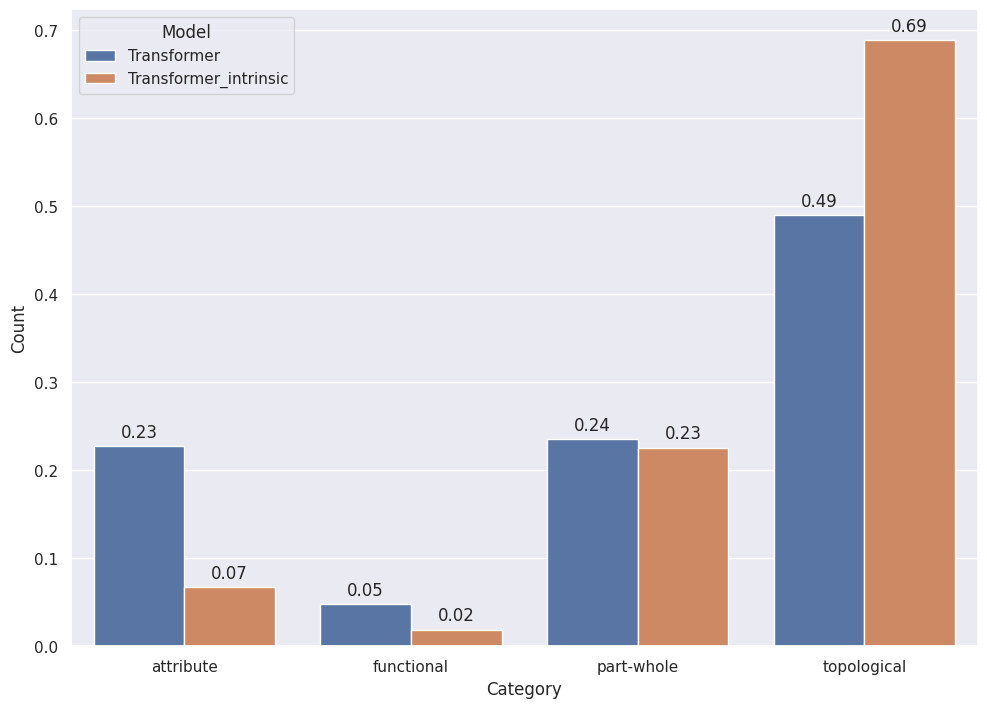

In [16]:
# display rels_count_1 and rels_count_2 as pie charts side by side using seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.DataFrame.from_dict(rels_count_1, orient='index', columns=['count'])
# transform count in relative percentage
df['count'] = df['count'] / df['count'].sum()
df['Model'] = 'Transformer'

df2 = pd.DataFrame.from_dict(rels_count_2, orient='index', columns=['count'])
df2['count'] = df2['count'] / df2['count'].sum()

df2['Model'] = 'Transformer_informative'

df = pd.concat([df, df2])

df = df.reset_index()
df = df.rename(columns={'index':'relation'})

df['relation'] = df['relation'].str.replace(' ', '\n')

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.barplot(x="relation", y="count", hue="Model", data=df)
# plot numbers on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
ax.set_xlabel("Category")
ax.set_ylabel("Count")
plt.xticks()
plt.show()